Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D

from keras.callbacks import ReduceLROnPlateau


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [60]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/CNN/Data_Store'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')
print(data_dir_train)

/content/gdrive/MyDrive/CNN/Data_Store/Train


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


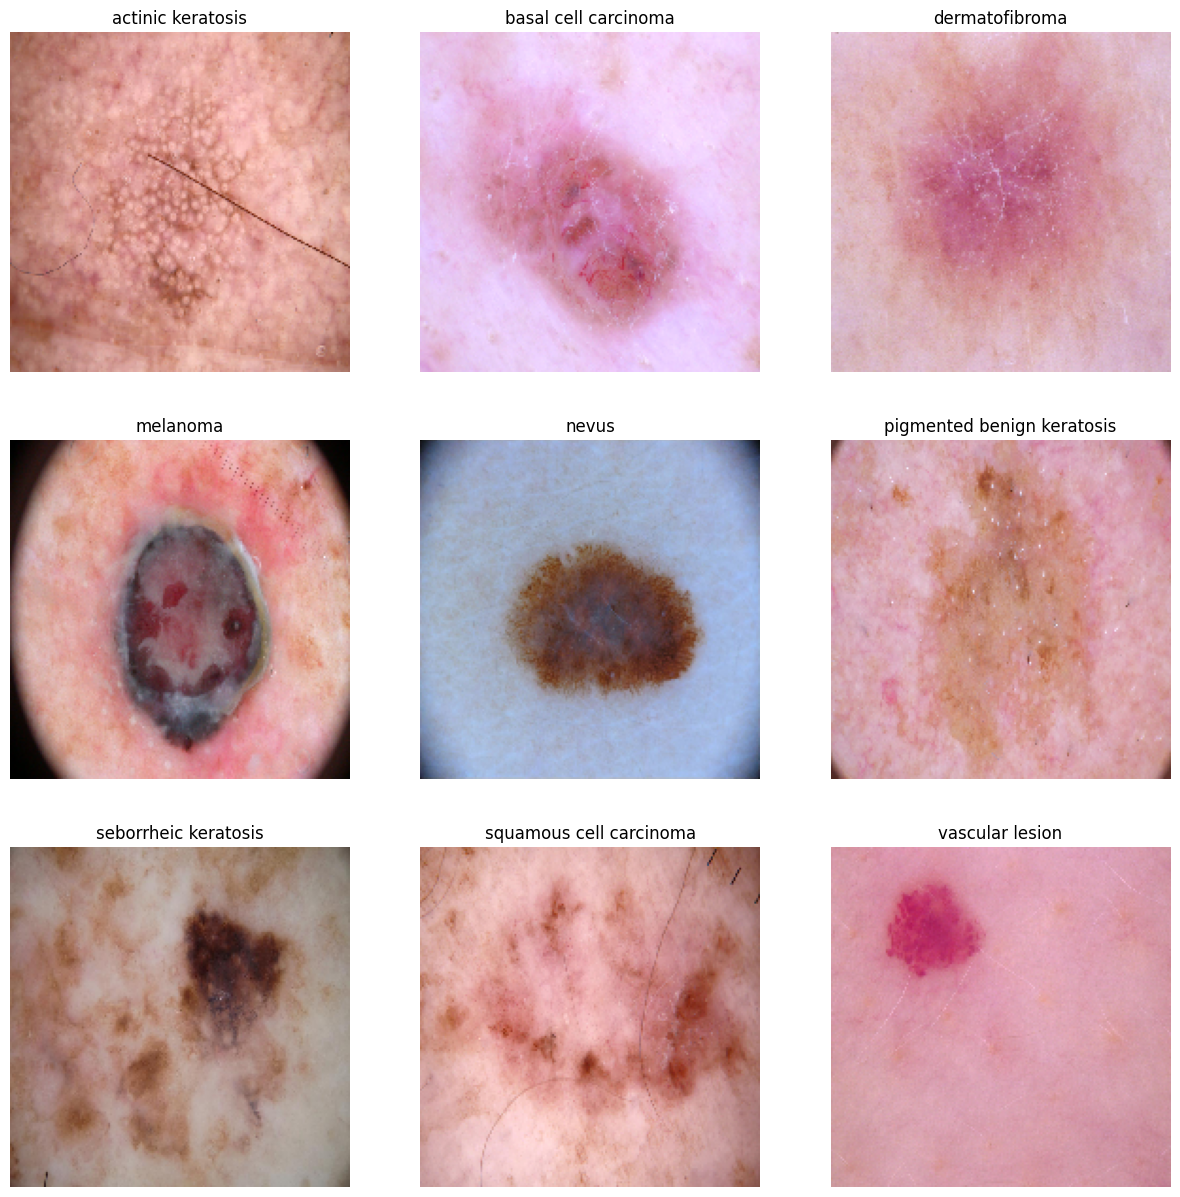

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

### your code goes here, you can use training or validation data to visualize

image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,squamous cell carcinoma,181
2,vascular lesion,139
3,seborrheic keratosis,77
4,dermatofibroma,95
5,melanoma,438
6,basal cell carcinoma,376
7,nevus,357
8,pigmented benign keratosis,462


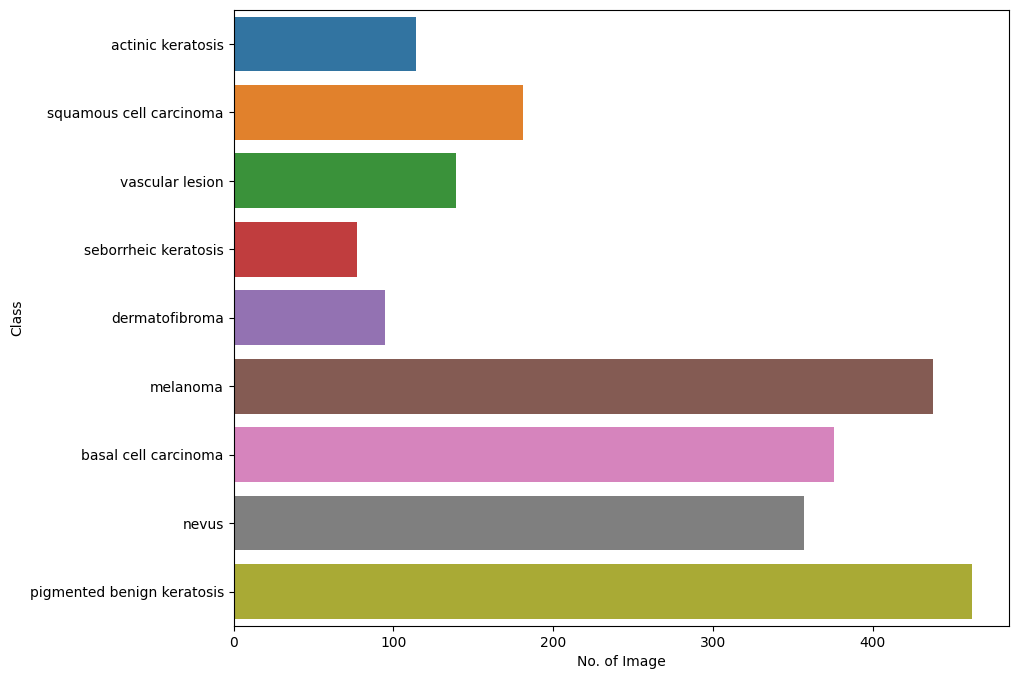

In [ ]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")
plt.show()

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes),
  layers.Dense(9,activation = 'softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [37]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 12s 209ms/step - loss: 1.5906 - accuracy: 0.4308 - val_loss: 1.5388 - val_accuracy: 0.4653
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4875 - accuracy: 0.4838 - val_loss: 1.4942 - val_accuracy: 0.5213
Epoch 3/20
56/56 [==============================] - 1s 22ms/step - loss: 1.3782 - accuracy: 0.5318 - val_loss: 1.4386 - val_accuracy: 0.5369
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3178 - accuracy: 0.5452 - val_loss: 1.3810 - val_accuracy: 0.5481
Epoch 5/20
56/56 [==============================] - 1s 22ms/step - loss: 1.2786 - accuracy: 0.5619 - val_loss: 1.4189 - val_accuracy: 0.5615
Epoch 6/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1859 - accuracy: 0.5837 - val_loss: 1.5258 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 1s 22ms/step - loss: 1.1296 - accuracy: 0.6133 - val_loss: 1.4295 - val_accuracy: 0.5615
Epoch 8/20


### Visualizing training results

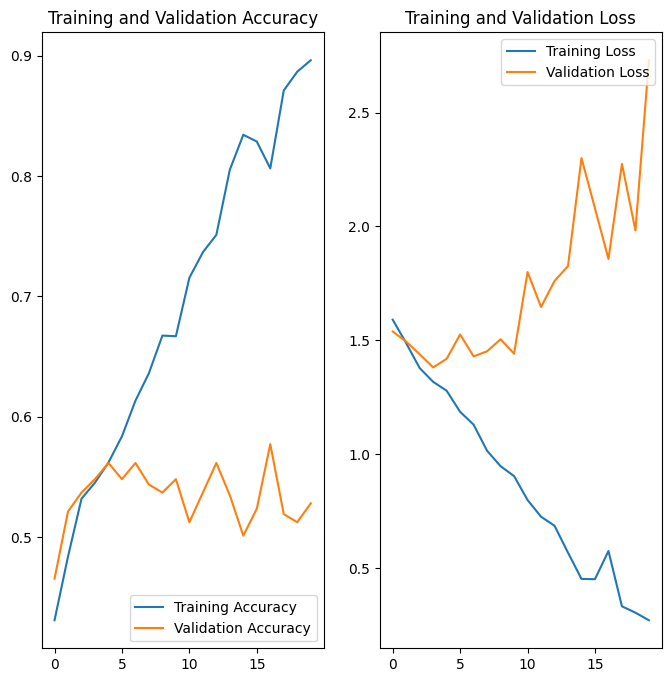

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit


### Write your findings here


Training Loss and Accuracy:

The training loss consistently decreases over the epochs, and the training accuracy steadily increases. This indicates that the model is learning the training data well.
Validation Loss and Accuracy:

The validation loss shows some fluctuations but doesn't follow a clear decreasing trend. It increases after a certain point (around epoch 14), which is indicative of overfitting.
The validation accuracy also shows fluctuations and doesn't improve consistently. It appears to plateau or slightly decrease after a certain number of epochs.
Overfitting Signs:

The increasing validation loss and the lack of significant improvement in validation accuracy after a certain point are evidence of overfitting.
The model might be fitting the noise in the training data rather than capturing generalizable patterns, leading to reduced performance on validation data.

The accuracy of the model for the Training data set is at 89%. But the Validation accuracy is not in par with the training accuracy.

In [46]:
model_update=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

In [47]:
model_update.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
epochs = 20
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 15s 132ms/step - loss: 2.1484 - accuracy: 0.1797 - val_loss: 2.0509 - val_accuracy: 0.2349
Epoch 2/20
56/56 [==============================] - 6s 110ms/step - loss: 2.0377 - accuracy: 0.1802 - val_loss: 2.0255 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 6s 108ms/step - loss: 2.0299 - accuracy: 0.2031 - val_loss: 2.0207 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 6s 110ms/step - loss: 2.0262 - accuracy: 0.1953 - val_loss: 2.0287 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 6s 108ms/step - loss: 2.0219 - accuracy: 0.1964 - val_loss: 2.0196 - val_accuracy: 0.2058
Epoch 6/20
56/56 [==============================] - 6s 110ms/step - loss: 2.0224 - accuracy: 0.2015 - val_loss: 2.0215 - val_accuracy: 0.1924
Epoch 7/20
56/56 [==============================] - 6s 110ms/step - loss: 2.0055 - accuracy: 0.2132 - val_loss: 1.9387 - val_accuracy: 0.3065
Epoch 8/20
56/56

 ### Observations

The model accuracy for Train data set has dropped to nearly 43%.

The accuracy for the Validation set is at 40%.

This is a much better model compared to the previous model as there seems to be No Overfit with the training accuracy 45% and validation accuracy at 40%.

In [50]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
#

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

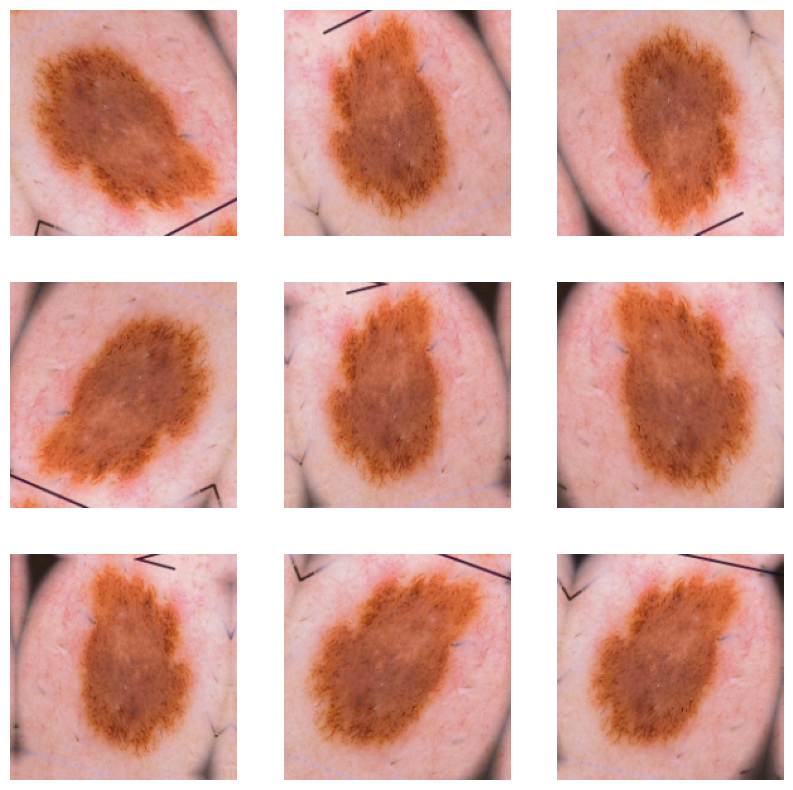

In [51]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here


image, label = next(iter(train_ds))
image=np.array(image,np.int32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)
  plt.imshow((augmented_image1))
  plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [52]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Flatten(),
    Dense(100, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])



### Compiling the model

In [54]:
## Your code goes here
model_augmented.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [56]:
## Your code goes here, note: train your model for 20 epochs
  ## your training code

epochs = 20
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 [==============================] - 11s 118ms/step - loss: 2.1751 - accuracy: 0.1858 - val_loss: 2.0616 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 6s 113ms/step - loss: 2.0490 - accuracy: 0.1897 - val_loss: 2.0384 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 7s 120ms/step - loss: 2.0310 - accuracy: 0.2188 - val_loss: 2.0303 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 6s 113ms/step - loss: 2.0355 - accuracy: 0.2009 - val_loss: 2.0326 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 7s 120ms/step - loss: 2.0311 - accuracy: 0.1953 - val_loss: 2.0228 - val_accuracy: 0.1924
Epoch 6/20
56/56 [==============================] - 6s 113ms/step - loss: 2.0297 - accuracy: 0.2065 - val_loss: 2.0275 - val_accuracy: 0.2282
Epoch 7/20
56/56 [==============================] - 7s 119ms/step - loss: 2.0261 - accuracy: 0.2132 - val_loss: 2.0266 - val_accuracy: 0.1924
Epoch 8/20
56/56

### Visualizing the results

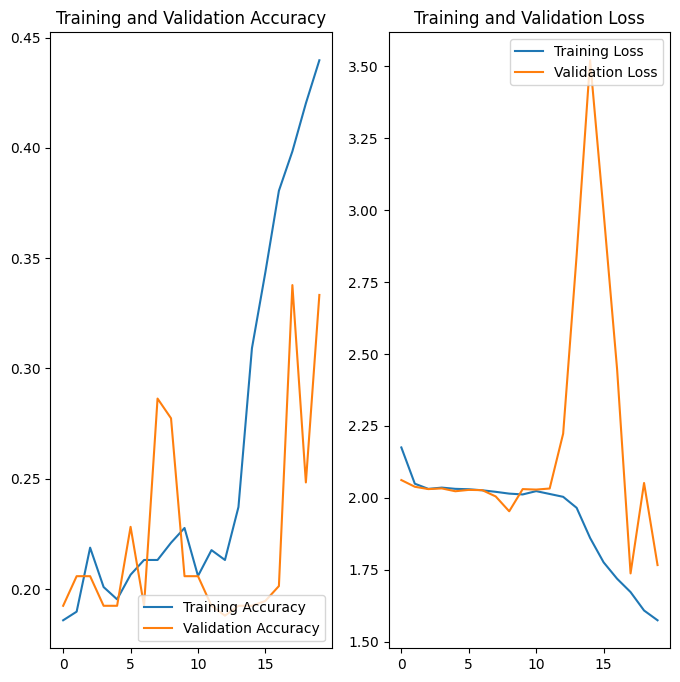

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Observations
The model accuracy for Train data set has gone up to nearly 43%.


The accuracy for the Validation set is also at 33%.


This is a much better model compared to the previous two models as there seems to be No Overfit with the training accuracy 43% and validation accuracy at 33%.
Data Augmentation has improved the model performance.

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [70]:
## Your code goes here.

for i in class_names:
    directory =train_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    print(f'{i} has {length} samples.')

actinic keratosis has 114 samples.
basal cell carcinoma has 376 samples.
dermatofibroma has 95 samples.
melanoma has 438 samples.
nevus has 357 samples.
pigmented benign keratosis has 462 samples.
seborrheic keratosis has 77 samples.
squamous cell carcinoma has 181 samples.
vascular lesion has 139 samples.


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


The samples of various classes are not in equal proportion.

There is a significant Class Imbalance observed.

The class with the least number of samples is Seborrheic Keratosis with 77.

The class that dominates the data in terms of proportionate number of samples is Pigmented Benign Keratosis with sample size of 462.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [58]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [69]:
train_path="/content/gdrive/MyDrive/CNN/Data_Store/Train/"


path_to_training_dataset=train_path

print(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/gdrive/MyDrive/CNN/Data_Store/Train/
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Data_Store/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4982C92E30>: 100%|██████████| 500/500 [00:23<00:00, 20.95 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Data_Store/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4982C5B9A0>: 100%|██████████| 500/500 [00:22<00:00, 22.72 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Data_Store/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A49828D4520>: 100%|██████████| 500/500 [00:19<00:00, 25.80 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Data_Store/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7A4982147880>: 100%|██████████| 500/500 [01:43<00:00,  4.84 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Data_Store/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7A4982146650>: 100%|██████████| 500/500 [01:28<00:00,  5.63 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Data_Store/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4982C92E30>: 100%|██████████| 500/500 [00:20<00:00, 24.05 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Data_Store/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7A49988D59F0>: 100%|██████████| 500/500 [00:46<00:00, 10.74 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Data_Store/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A4A391BBA90>: 100%|██████████| 500/500 [00:22<00:00, 22.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN/Data_Store/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A4998A7FCA0>: 100%|██████████| 500/500 [00:21<00:00, 23.35 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [71]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [72]:
import glob
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/gdrive/MyDrive/CNN/Data_Store/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028076.jpg_1f36976a-3be2-497e-a31c-950e9e272a1f.jpg',
 '/content/gdrive/MyDrive/CNN/Data_Store/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_3f3ef365-708a-4afb-951a-fe9942ab4389.jpg',
 '/content/gdrive/MyDrive/CNN/Data_Store/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_52674931-181d-4220-908f-b72415512f68.jpg',
 '/content/gdrive/MyDrive/CNN/Data_Store/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033358.jpg_ad4f1259-b507-462e-9416-47463174eda2.jpg',
 '/content/gdrive/MyDrive/CNN/Data_Store/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029915.jpg_b2f04e51-b3cb-46c6-b0ac-0b558ab0b808.jpg',
 '/content/gdrive/MyDrive/CNN/Data_Store/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029830.jpg_4c0aad29-0194-4346-9d3c-c37a752b2682.jpg',
 '/content/gdrive/MyDrive/CNN/Data_Store/Train

In [74]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [75]:
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df


dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/CNN/Data_Store/Train/a...,actinic keratosis
1,/content/gdrive/MyDrive/CNN/Data_Store/Train/a...,actinic keratosis
2,/content/gdrive/MyDrive/CNN/Data_Store/Train/a...,actinic keratosis
3,/content/gdrive/MyDrive/CNN/Data_Store/Train/a...,actinic keratosis
4,/content/gdrive/MyDrive/CNN/Data_Store/Train/a...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/CNN/Data_Store/Train/v...,vascular lesion
2235,/content/gdrive/MyDrive/CNN/Data_Store/Train/v...,vascular lesion
2236,/content/gdrive/MyDrive/CNN/Data_Store/Train/v...,vascular lesion
2237,/content/gdrive/MyDrive/CNN/Data_Store/Train/v...,vascular lesion


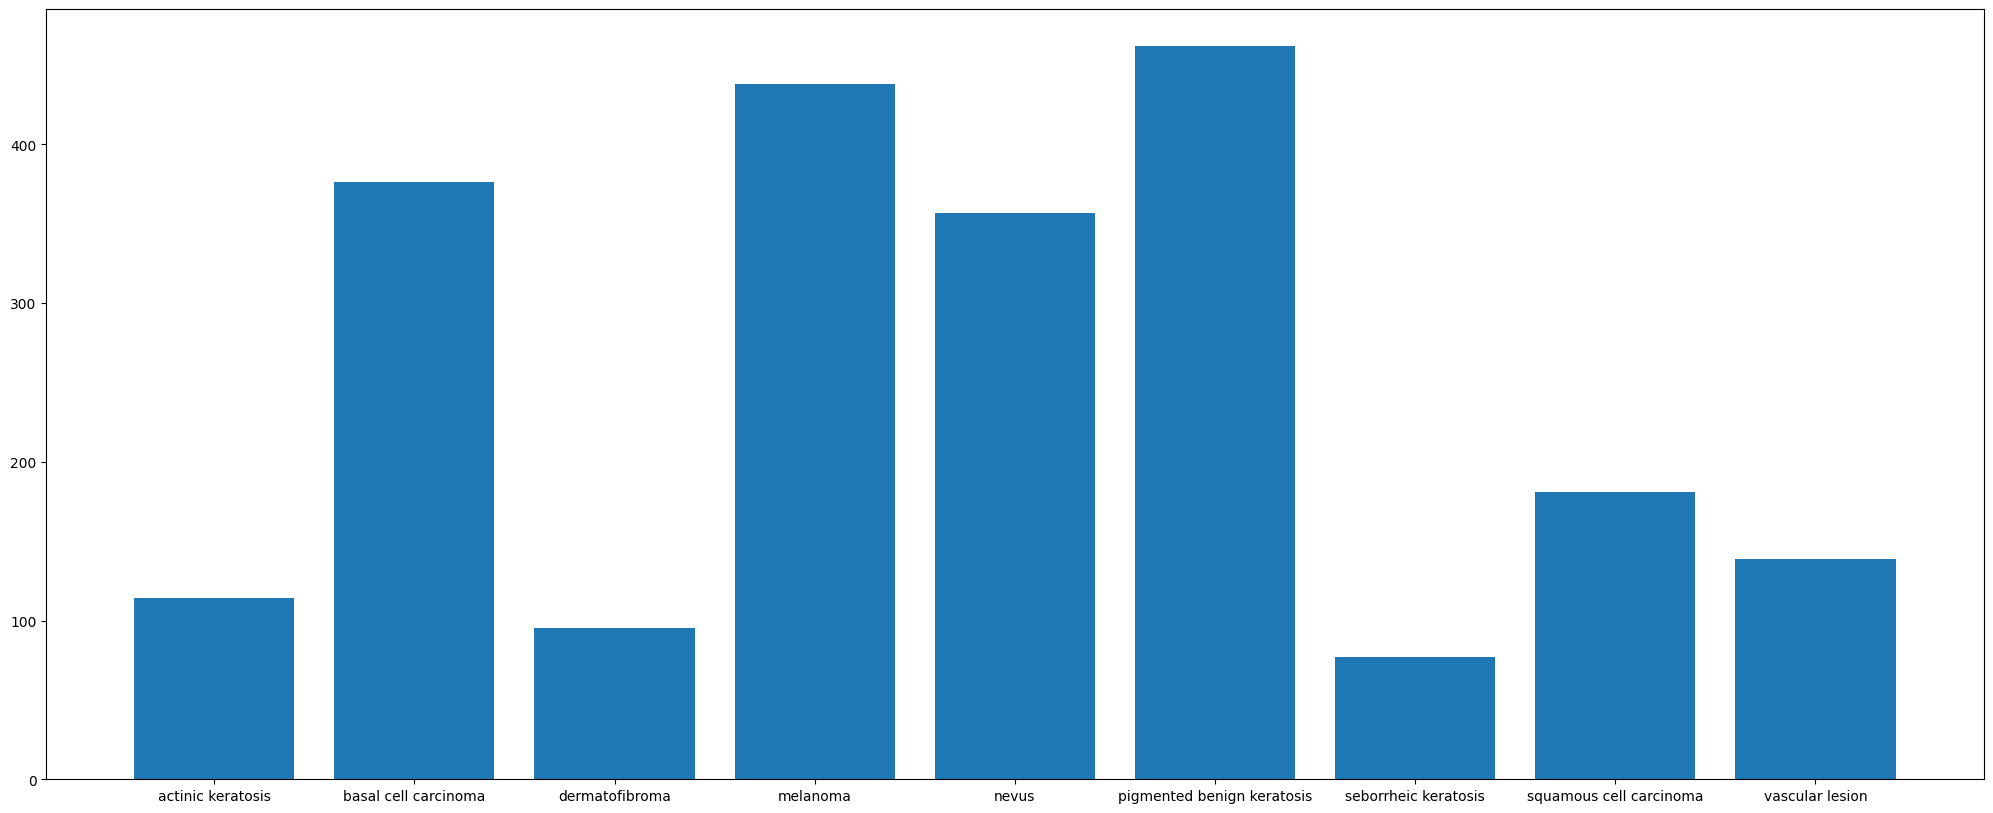

In [76]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)
plt.show()

In [77]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [78]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

<ipython-input-78-17a6b079869a>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = original_df.append(df2)


In [79]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [80]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [81]:
data_dir_train="/content/gdrive/MyDrive/CNN/Data_Store/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [82]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [83]:
model_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [84]:
## your code goes here

model_final.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [85]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 43s 226ms/step - loss: 2.2715 - accuracy: 0.2109 - val_loss: 1.8662 - val_accuracy: 0.3029
Epoch 2/30
169/169 [==============================] - 39s 225ms/step - loss: 1.6707 - accuracy: 0.3665 - val_loss: 1.4127 - val_accuracy: 0.4759
Epoch 3/30
169/169 [==============================] - 40s 230ms/step - loss: 1.3947 - accuracy: 0.4872 - val_loss: 1.2374 - val_accuracy: 0.5531
Epoch 4/30
169/169 [==============================] - 38s 217ms/step - loss: 1.2523 - accuracy: 0.5482 - val_loss: 1.1594 - val_accuracy: 0.5917
Epoch 5/30
169/169 [==============================] - 36s 204ms/step - loss: 1.0877 - accuracy: 0.6096 - val_loss: 1.0211 - val_accuracy: 0.6385
Epoch 6/30
169/169 [==============================] - 39s 225ms/step - loss: 0.9415 - accuracy: 0.6619 - val_loss: 0.9455 - val_accuracy: 0.6585
Epoch 7/30
169/169 [==============================] - 37s 213ms/step - loss: 0.8168 - accuracy: 0.7070 - val_loss: 0.8846 - val_accuracy: 0.6

#### **Todo:**  Visualize the model results

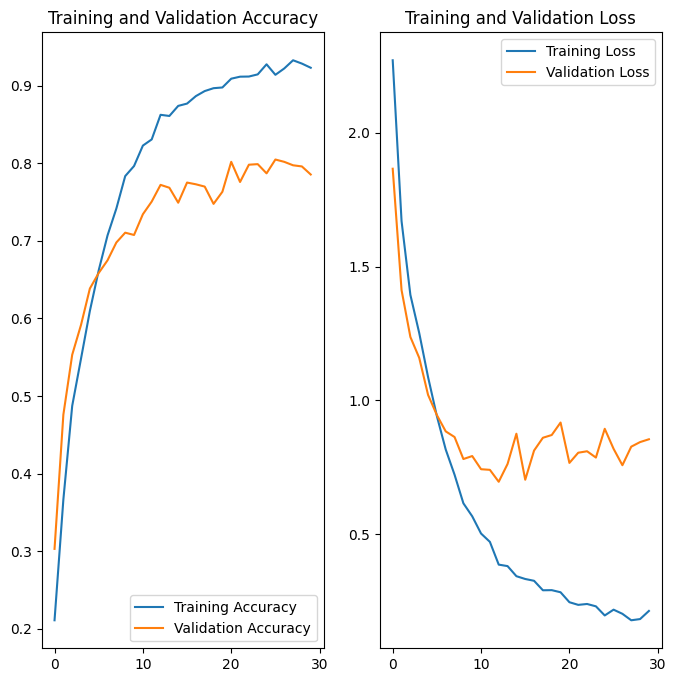

In [86]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The training accuracy seems to be nearly ~90 - 93%.

The validation accuracy is nearly ~78 - 80%.

Though the model accuracy has improved, the class rebalance has helped treat the overfitting to some extent.

Much better models could be built or tried out using more epochs and more layers.